# ABS tutorial 03

## partial-sky ABS pipeline (without noise)

To validate the ABS method we have simulated a few foregrounds maps including dust and synchrotron at 30, 95, 150 and 353 GHz, using PySM package. CAMB is utilized to predict the CMB power spectra with respect to the Planck best fit 2018 results, from which random realizations of CMB anisotropies are obtained. For the tensor-to-scalar ratio, we set it as 0.05 for the generation of CMB maps. White noise maps are generated according to the Planck level.

In [1]:
import numpy as np
import healpy as hp
import matplotlib
import abspy as ap
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

### read in maps

In [2]:
NSIDE = 128
map30 = hp.read_map('./data/TQU_30GHz_r7.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map95 = hp.read_map('./data/TQU_95GHz_r7.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map150 = hp.read_map('./data/TQU_150GHz_r7.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map353 = hp.read_map('./data/TQU_353GHz_r7.fits',field=[0,1,2],dtype=np.float32,verbose=0)
mapcmb = hp.read_map('./data/TQU_CMB_r7.fits',field=[0,1,2],dtype=np.float32,verbose=0)

fwhm = [0.5*np.pi/180.,0.3*np.pi/180.,0.2*np.pi/180.,0.08*np.pi/180.]
map30 = hp.smoothing(map30,fwhm=fwhm[0])
map95 = hp.smoothing(map95,fwhm=fwhm[1])
map150 = hp.smoothing(map150,fwhm=fwhm[2])
map353 = hp.smoothing(map353,fwhm=fwhm[3])

Sigma is 12.739827 arcmin (0.003706 rad) 
-> fwhm is 30.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 7.643896 arcmin (0.002224 rad) 
-> fwhm is 18.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 5.095931 arcmin (0.001482 rad) 
-> fwhm is 12.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 2.038372 arcmin (0.000593 rad) 
-> fwhm is 4.800000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


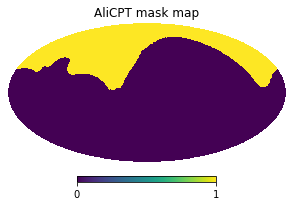

In [3]:
mask = hp.read_map('./data/ali_mask_r7.fits',dtype=bool,verbose=False)

fig = matplotlib.pyplot.figure(figsize=(5,5))
gs = matplotlib.gridspec.GridSpec(5, 5)
fig.add_subplot(gs[0:5, 0:5])
hp.mollview(mask,title='AliCPT mask map',hold=True)

- PS estimation requires a built-in PS estimator (by default NaMaster)
- use `abspipe`

(10, 384)

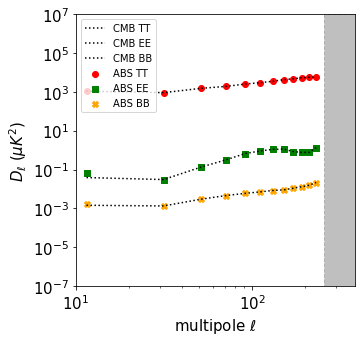

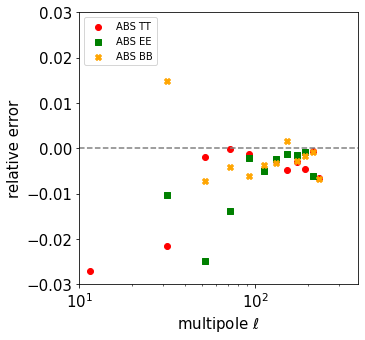

In [5]:
BINNING = 20
est = ap.pstimator(nside=NSIDE, mask=mask.reshape(1,-1),aposcale=6.0,psbin=BINNING)
auto_cmb_t = est.auto_t(mapcmb[0].reshape(1,-1))
auto_cmb_eb = est.auto_eb(mapcmb[1:])

# T maps
fullmap = np.zeros((4,1,12*NSIDE**2))
fullmap[0] = map30[0].reshape(1,-1)
fullmap[1] = map95[0].reshape(1,-1)
fullmap[2] = map150[0].reshape(1,-1)
fullmap[3] = map353[0].reshape(1,-1)
pipeline = ap.abspipe(fullmap,nfreq=4,nmap=1,nside=NSIDE,mask=mask.reshape(1,-1),fwhms=fwhm)
rslt_t = pipeline(aposcale=6.,psbin=BINNING,shift=None,threshold=None)

# Q,U maps
fullmap = np.zeros((4,2,12*NSIDE**2))
fullmap[0] = map30[1:]
fullmap[1] = map95[1:]
fullmap[2] = map150[1:]
fullmap[3] = map353[1:]
pipeline = ap.abspipe(fullmap,nfreq=4,nmap=2,nside=NSIDE,mask=mask.reshape(1,-1),fwhms=fwhm)
rslt_eb = pipeline(aposcale=6.,psbin=BINNING,shift=None,threshold=None)


fig,ax = matplotlib.pyplot.subplots(figsize=(5,5))

ax.scatter(rslt_t[0],rslt_t[1],
           color='red',marker='o',label=r'ABS TT')
ax.scatter(rslt_eb[0],rslt_eb[1],
           color='green',marker='s',label=r'ABS EE')
ax.scatter(rslt_eb[0],rslt_eb[2],
           color='orange',marker='X',label=r'ABS BB')

ax.plot(auto_cmb_t[0],auto_cmb_t[1],color='black',linestyle=':',label=r'CMB TT')
ax.plot(auto_cmb_eb[0],auto_cmb_eb[1],color='black',linestyle=':',label=r'CMB EE')
ax.plot(auto_cmb_eb[0],auto_cmb_eb[2],color='black',linestyle=':',label=r'CMB BB')

ax.fill_between((2*NSIDE,3*NSIDE),(1e-7,1e-7),(1e7,1e7),
                color='gray',linestyle='--',alpha=0.5)

ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(loc=2)
ax.set_xlabel(r'multipole $\ell$',fontsize=15)
ax.set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_ylim((1.e-7,1.e7))
ax.set_xlim((10,3*NSIDE))

fig,ax = matplotlib.pyplot.subplots(figsize=(5,5))

ax.scatter(rslt_t[0],(rslt_t[1]-auto_cmb_t[1])/auto_cmb_t[1],
            color='red',marker='o',label=r'ABS TT')
ax.scatter(rslt_eb[0],(rslt_eb[1]-auto_cmb_eb[1])/auto_cmb_eb[1],
            color='green',marker='s',label=r'ABS EE')
ax.scatter(rslt_eb[0],(rslt_eb[2]-auto_cmb_eb[2])/auto_cmb_eb[2],
            color='orange',marker='X',label=r'ABS BB')
ax.plot((10,3*NSIDE),(0,0),color='grey',linestyle='--')

ax.set_xscale('log')
ax.legend(loc=2)
ax.set_xlabel(r'multipole $\ell$',fontsize=15)
ax.set_ylabel(r'relative error',fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_ylim((-0.03,0.03))
ax.set_xlim((10,3*NSIDE))

end